In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import graphviz

In [47]:
import mlflow

In [3]:
autolog()

## Read data

In [7]:
df = pd.read_csv('data/AdSmartABdata.csv', parse_dates=['date'])

In [ ]:
df.head()

In [8]:
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [ ]:
df.info()

# Counts of categorical Variables

## Experiment value counts

In [9]:
df['experiment'].value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

## Experiment value visualization

<AxesSubplot:>

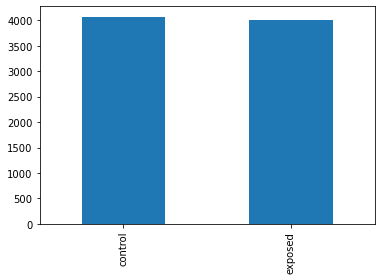

In [10]:
df['experiment'].value_counts().plot(kind='bar')

## Device make value counts

In [11]:
df['device_make'].value_counts()

Generic Smartphone    4743
iPhone                 433
Samsung SM-G960F       203
Samsung SM-G973F       154
Samsung SM-G950F       148
                      ... 
IMO $2                   1
Samsung SM-A305F         1
Samsung SM-G930U         1
Samsung SM-G570F         1
5008Y_EEA                1
Name: device_make, Length: 270, dtype: int64

## Browser value counts

In [12]:
df['browser'].value_counts()

Chrome Mobile                 4554
Chrome Mobile WebView         1489
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Opera Mobile                     3
Chrome                           3
Pinterest                        3
Opera Mini                       1
Android                          1
Edge Mobile                      1
Puffin                           1
Firefox Mobile                   1
Name: browser, dtype: int64

<AxesSubplot:title={'center':'Browsers'}>

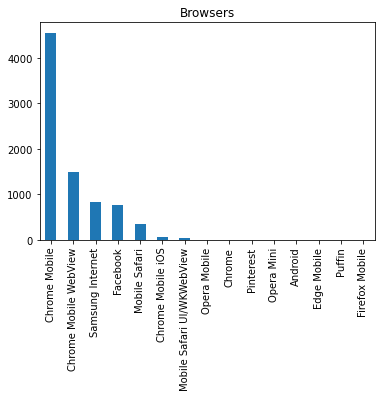

In [13]:
df['browser'].value_counts().plot(kind='bar', title='Browsers')

## Hour values plot

<AxesSubplot:title={'center':'Hour values'}, ylabel='Density'>

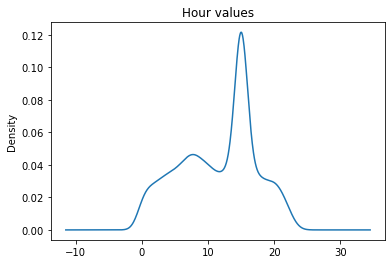

In [14]:
df['hour'].plot(kind='kde', title='Hour values')

## Yes answers plot

<AxesSubplot:title={'center':'Yes Answers'}, ylabel='Density'>

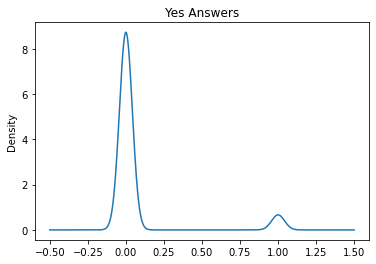

In [15]:
df['yes'].plot(kind='kde', title='Yes Answers')

## No answers plot

<AxesSubplot:title={'center':'No Answers'}, ylabel='Density'>

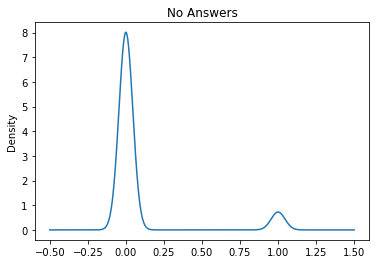

In [16]:
df['no'].plot(kind='kde', title='No Answers')

## Platform_Os values plot

<AxesSubplot:title={'center':'Platform_os'}, ylabel='Density'>

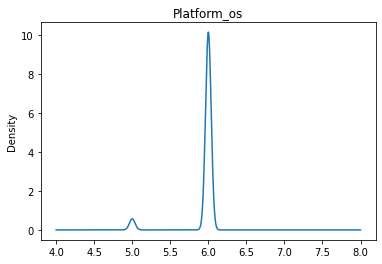

In [17]:
df['platform_os'].plot(kind='kde', title='Platform_os')

## XGBoost model

### Get index for entries with a 'yes' or 'no' answer

In [18]:
answered_index = ((df['yes'] == 1) | (df['no'] ==1))

### Clean the data

In [19]:
cleaned_df = df[answered_index].copy()
cleaned_df.reset_index(drop=True, inplace=True)          # reset the index

### Get the data for the modeling proccess

In [20]:
model_df = cleaned_df[cleaned_df.columns[:-1]].copy()    # create data to be used for modeling
model_df.rename(columns={'yes':'answer'}, inplace=True)  # rename the 'yes' column to 'answer'

### Split data by browser and platform_os

In [21]:
model_df_browser = model_df[['auction_id', 'experiment', 'date', 'hour', 'device_make', 'browser', 'answer']].copy()
model_df_platform_os = model_df[['auction_id', 'experiment', 'date', 'hour', 'device_make', 'platform_os', 'answer']].copy()

In [22]:
 train_brwsr, test_brwsr, validate_brwsr  = \
              np.split(model_df_browser[model_df_browser.columns[1:]].sample(frac=1, random_state=42), 
                       [int(.7*len(model_df_browser)), int(.9*len(model_df_browser))])

In [23]:
brwsr_X_col = model_df_browser.columns[1:-1]

brwsr_train =  train_brwsr[brwsr_X_col]
brwsr_train_labels = train_brwsr['answer']

brwsr_test =  test_brwsr[brwsr_X_col]
brwsr_test_labels = test_brwsr['answer']

brwsr_val =  validate_brwsr[brwsr_X_col]
brwsr_val_labels = validate_brwsr['answer']

In [24]:
numerical_browser = ['date','hour']
cat_browser = ['experiment', 'device_make', 'browser']

In [25]:
class ExtractDay(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self               # take the date column and pss to self
    
    def transform(self, X, y=None):
        X= X.copy()
        X['date'] = X['date'].apply(lambda x:x.weekday())
        return X

In [26]:
numerical_platform_os = ['date','hour','platform_os']
cat_platform_os = ['experiment', 'device_make']

In [27]:
num_pipeline = Pipeline([
    ('day_extractor', ExtractDay()),
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numerical_browser),
    ('cat', OneHotEncoder(), numerical_browser)
])

In [28]:
brswr_train_processed = full_pipeline.fit_transform(brwsr_train)
brswr_test_processed = full_pipeline.fit_transform(brwsr_test)
brswr_val_processed = full_pipeline.fit_transform(brwsr_val)

In [38]:
autolog()

In [42]:
params ={'objective':'binary:logistic', 'learning_rate':0.1, 'max_depth':5, 'random_state':42, 'use_label_encoder':False}

In [ ]:
mlflow.create_experiment('tes')

In [56]:
mlflow.set_experiment('test')

In [57]:
clf_xgb = xgb.XGBClassifier(base_score=0.5, max_depth=5, learning_rate=0.1, random_state=42, objective='binary:logistic', use_label_encoder=False)

clf_xgb.fit(brswr_test_processed, brwsr_test_labels)

[15:40:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [58]:
mlflow.xgboost.autolog(clf_xgb) 

In [32]:
y_predicted = clf_xgb.predict(brswr_test_processed)

In [33]:
rms = mean_squared_error(brwsr_test_labels, y_predicted, squared=False)

In [34]:
rms

0.5462482007056806

In [35]:
data_dmatrix = xgb.DMatrix(data=brswr_val_processed, label=brwsr_val_labels)

In [41]:
cv_result = xgb.cv(params=params,dtrain=data_dmatrix, nfold=5, metrics='rmse', stratified=True, as_pandas=True, seed=42)

[15:12:36] WARNING: ..\src\learner.cc:541: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:12:36] WARNING: ..\src\learner.cc:541: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:12:36] WARNING: ..\src\learner.cc:541: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

In [37]:
cv_result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.492157,0.001552,0.500474,0.002983
1,0.485125,0.003225,0.501634,0.006762
2,0.478705,0.004974,0.503194,0.010466
3,0.473251,0.006493,0.504896,0.013706
4,0.468045,0.008231,0.507070,0.017209
5,0.463675,0.009166,0.508848,0.020203
6,0.459619,0.010027,0.511585,0.023194
7,0.456067,0.010868,0.512802,0.025839
8,0.452709,0.011336,0.515103,0.027396
9,0.449853,0.011679,0.517400,0.028995


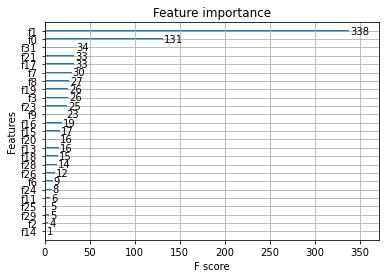

In [59]:
xgb.plot_importance(clf_xgb)
plt.rcParams['figure.figsize'] = [20, 20]

In [ ]:
train_os, test_os, validate_so  = \
              np.split(model_df_platform_os[model_df_platform_os.columns[1:]].sample(frac=1, random_state=42), 
                       [int(.7*len(model_df_platform_os)), int(.9*len(model_df_platform_os))])